In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from catboost import CatBoostRegressor, Pool

In [2]:
# Paths
DATA_DIR = Path("../data/processed")
OUTPUT_MERGED = DATA_DIR / "merged_all_assets.csv"
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Load the merged dataset from the LightGBM notebook
df_all = pd.read_csv(OUTPUT_MERGED)
df_all["Date"] = pd.to_datetime(df_all["Date"])
df_all = df_all.sort_values("Date").reset_index(drop=True)

print(f"Dataset shape: {df_all.shape}")
df_all.head()

Dataset shape: (12351, 24)


,Date,Close,High,Low,Open,Volume,Ticker,Return,Volatility_5d,Volatility_21d,...,ATR_14,SMA_20,SMA_50,SMA_200,tweet_sentiment_mean,tweet_sentiment_std,tweet_count,news_sentiment_mean,news_sentiment_std,news_count
0,2015-10-13,10115.290039,10229.289929,10049.790102,10227.390517,259780200,IBEX35,-0.012795,0.159683,0.269366,...,219.585324,9811.945020,10157.991777,10819.799014,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-10-14,10037.589844,10128.990145,9992.390669,10065.390598,253688800,IBEX35,-0.007681,0.156205,0.270263,...,213.657763,9814.985010,10133.153809,10818.233018,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-10-15,10101.690430,10132.690400,10055.089889,10132.089814,239299900,IBEX35,0.006386,0.168101,0.262564,...,205.189391,9814.740039,10110.115859,10818.775020,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-10-16,10231.489258,10243.989245,10153.088950,10174.889708,246079200,IBEX35,0.012849,0.169364,0.262469,...,200.697207,9833.954980,10091.181875,10820.577017,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-10-16,2033.109985,2033.540039,2020.459961,2024.369995,3595430000,S&P500,0.004570,0.136368,0.176075,...,27.336910,1966.829993,1984.670801,2059.898853,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Define features and target
TARGET = "Volatility_5d"

feature_cols = [
    # Market features
    "Return", "Volatility_21d", "RSI_14", "MACD", "MACD_signal",
    "MACD_hist", "ATR_14", "SMA_20", "SMA_50", "SMA_200",
    # Sentiment features
    "tweet_sentiment_mean", "tweet_sentiment_std", "tweet_count",
    "news_sentiment_mean", "news_sentiment_std", "news_count",
    # Add categorical ticker
    "Ticker"
]

# Drop rows with NaNs in features or target
df_all = df_all.dropna(subset=feature_cols + [TARGET])
print(f"Dataset after cleaning: {df_all.shape}")

Dataset after cleaning: (12351, 24)


In [5]:
# Train/Test split
split_idx = int(len(df_all) * 0.8)
train_df = df_all.iloc[:split_idx]
test_df = df_all.iloc[split_idx:]

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 9880, Test size: 2471


In [6]:
# Separate features and target
X_train = train_df[feature_cols]
y_train = train_df[TARGET]
X_test  = test_df[feature_cols]
y_test  = test_df[TARGET]

# CatBoost handles categorical features natively
cat_features = ["Ticker"]

# Create CatBoost Pool objects
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [7]:
# Train CatBoost model
model_cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_SEED,
    early_stopping_rounds=50,
    verbose=100
)

model_cb.fit(train_pool, eval_set=test_pool)

0:	learn: 0.1458329	test: 0.1215664	best: 0.1215664 (0)	total: 285ms	remaining: 9m 28s
100:	learn: 0.0688704	test: 0.0758876	best: 0.0758217 (99)	total: 19.1s	remaining: 5m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07582168628
bestIteration = 99

Shrink model to first 100 iterations.


In [8]:
# Save model
model_cb.save_model(str(MODELS_DIR / "volatility_model_multimodal_catboost.cbm"))

In [9]:
# Prediction and metrics
y_pred = model_cb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.0758
MAE: 0.0499
R²: 0.6163


In [10]:
# Save predictions
pred_df = pd.DataFrame({
    "Date": test_df["Date"].values,
    "Ticker": test_df["Ticker"].values,
    "Actual_Volatility": y_test.values,
    "Predicted_Volatility": y_pred
})

pred_df.to_csv(MODELS_DIR / "predictions_multimodal_catboost.csv", index=False)
pred_df.head()

,Date,Ticker,Actual_Volatility,Predicted_Volatility
0,2023-08-14,AAPL,0.110425,0.244811
1,2023-08-14,MSFT,0.148567,0.309660
2,2023-08-15,MSFT,0.132586,0.291616
3,2023-08-15,AAPL,0.130014,0.211417
4,2023-08-15,IBEX35,0.159442,0.139628


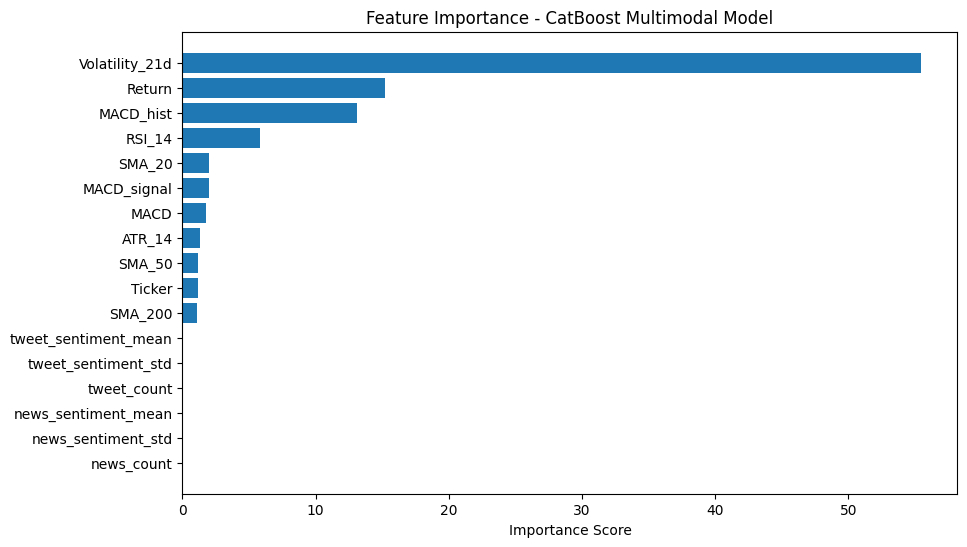

In [11]:
# Feature importance
importances = model_cb.get_feature_importance(train_pool)
importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - CatBoost Multimodal Model")
plt.xlabel("Importance Score")
plt.show()

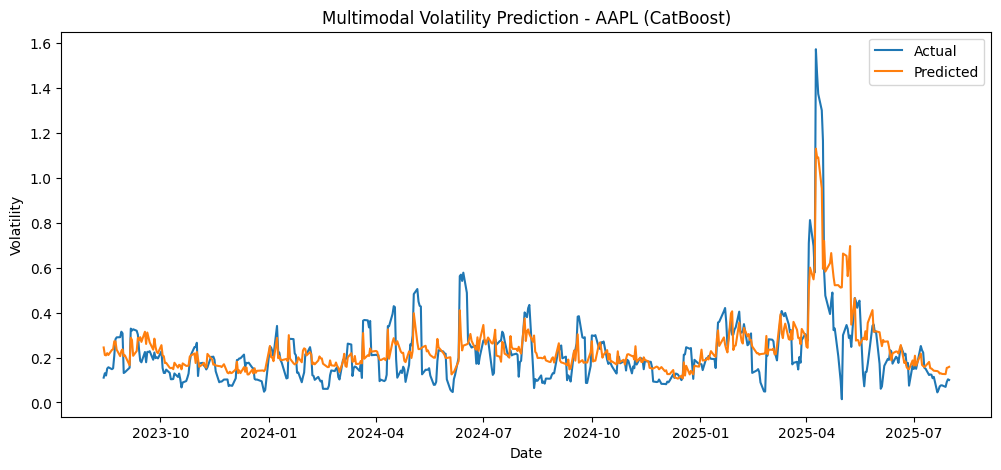

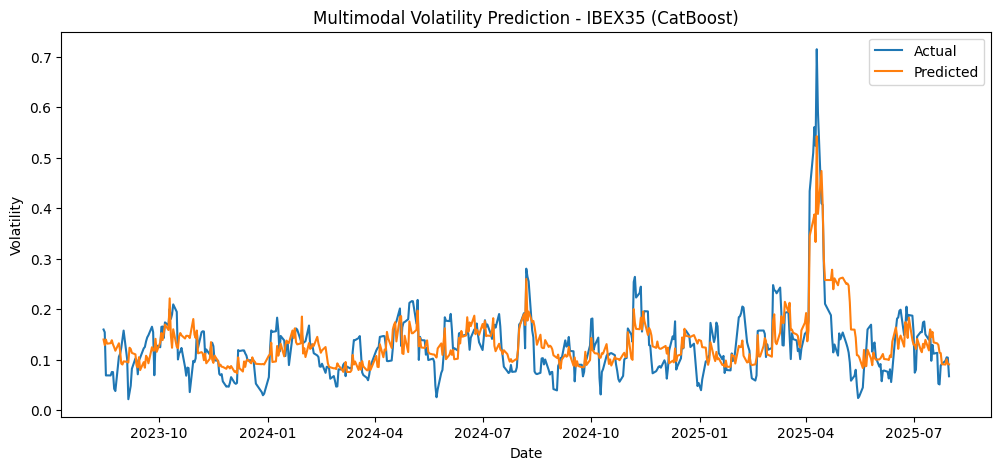

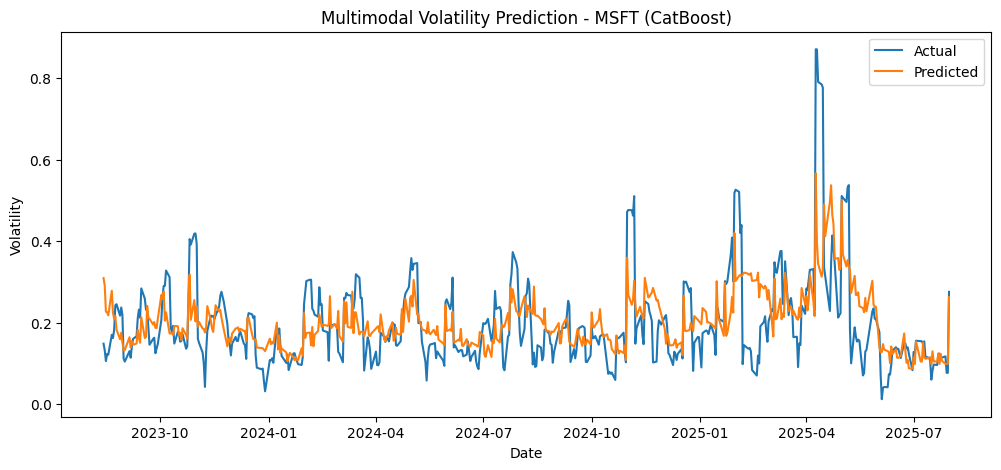

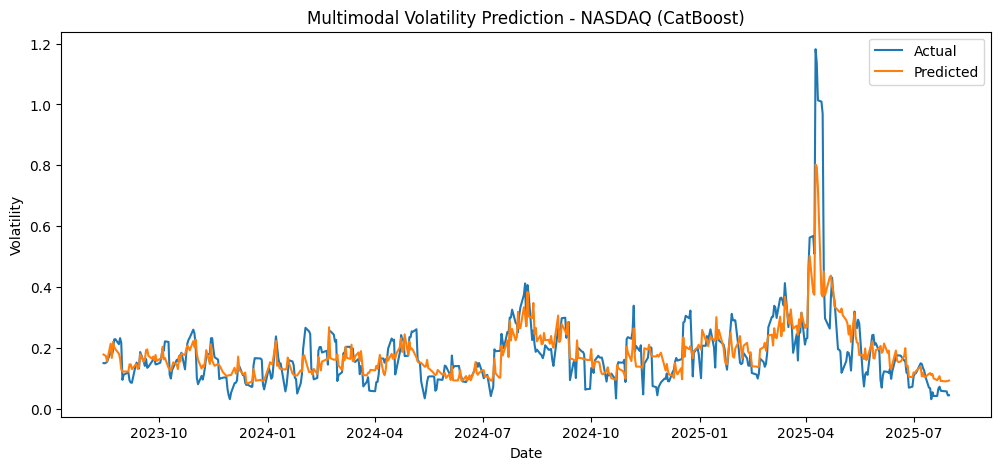

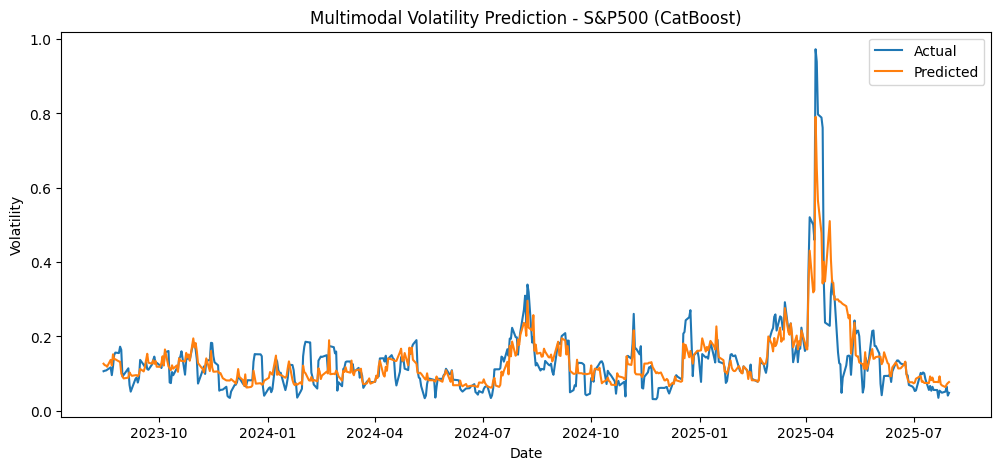

In [12]:
# Visualization of predictions
ASSETS = ["AAPL", "IBEX35", "MSFT", "NASDAQ", "S&P500"]

for asset in ASSETS:
    asset_df = pred_df[pred_df["Ticker"] == asset]

    plt.figure(figsize=(12,5))
    plt.plot(asset_df["Date"], asset_df["Actual_Volatility"], label="Actual")
    plt.plot(asset_df["Date"], asset_df["Predicted_Volatility"], label="Predicted")
    plt.title(f"Multimodal Volatility Prediction - {asset} (CatBoost)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()